In [1]:
import FinancialMachineLearning as fml
import FinancialMultiProcessing as fmp

In [2]:
from pathlib import PurePath, Path
import sys
import time
from collections import OrderedDict as od
import re
import os
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
pd.set_option('display.max_rows',100)
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
import scipy.stats as stats
import statsmodels.api as sm
from numba import jit
import math
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib as mpl
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

In [3]:
df = pd.read_parquet('./Data/IVE_dollarValue_resampled_1s.parquet')
df

,price,bid,ask,size,v,dv
2009-09-28 09:30:00,50.75,50.70,50.79,369.0,369.0,1.871599e+04
2009-09-28 09:31:32,50.75,50.75,50.76,100.0,100.0,5.075000e+03
2009-09-28 09:31:33,50.75,50.72,50.75,100.0,100.0,5.075000e+03
2009-09-28 09:31:50,50.75,50.73,50.76,300.0,300.0,1.522500e+04
2009-09-28 09:31:51,50.75,50.74,50.76,300.0,300.0,1.522500e+04
...,...,...,...,...,...,...
2018-02-26 15:59:59,115.35,115.34,115.36,412.5,412.5,4.758188e+04
2018-02-26 16:00:00,115.35,115.34,115.35,5362.0,5362.0,6.185067e+05
2018-02-26 16:10:00,115.35,115.22,115.58,0.0,0.0,0.000000e+00
2018-02-26 16:16:14,115.30,114.72,115.62,778677.0,778677.0,8.978146e+07


In [4]:
df['dates'] = df.index
dbars = fml.bar_sampling(df, 'dv', 1000000).drop_duplicates().dropna()
dbars = dbars.drop(['dates'], axis = 1)
dbars

,price,bid,ask,size,v,dv
2009-09-28 09:53:49,51.138000,51.130000,51.140000,970.200000,970.200000,4.961503e+04
2009-09-28 10:06:04,51.190000,51.190000,51.200000,100.000000,100.000000,5.119000e+03
2009-09-28 10:19:50,51.210000,51.210000,51.220000,100.000000,100.000000,5.121000e+03
2009-09-28 10:32:01,51.379725,51.360000,51.380000,575.000000,575.000000,2.954327e+04
2009-09-28 10:53:46,51.330000,51.320000,51.330000,1500.000000,1500.000000,7.699500e+04
...,...,...,...,...,...,...
2018-02-26 15:31:06,115.290000,115.280000,115.290000,2022.000000,2022.000000,2.331164e+05
2018-02-26 15:40:15,115.410000,115.400000,115.410000,723.000000,723.000000,8.344143e+04
2018-02-26 15:49:42,115.200000,115.176667,115.186667,4487.166667,4487.166667,5.171190e+05
2018-02-26 15:59:04,115.270000,115.260000,115.270000,300.000000,300.000000,3.458100e+04


In [5]:
close = dbars.price.copy()
dailyVol = fml.getDailyVolatility(close)

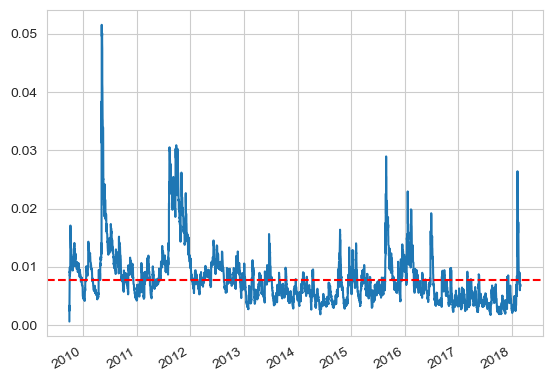

In [6]:
f, ax = plt.subplots()
dailyVol.plot(ax = ax)
ax.axhline(dailyVol.mean(), ls = '--', color = 'red')

In [7]:
from tqdm import tqdm, tqdm_notebook

tEvents = fml.getTEvents(close, h = dailyVol.mean())
t1 = fml.addVerticalBarrier(tEvents, close)

ptSl = [1, 1]
target = dailyVol

100%|██████████| 30859/30859 [00:00<00:00, 36375.49it/s]


In [8]:
minRet = 0.001
import platform
from multiprocessing import cpu_count
if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1

In [9]:
events = fml.getEvents(close, tEvents, ptSl, target, minRet, 1, t1 = t1)
numThreads = cpus
numCoEvents = fmp.mpPandasObj(fmp.mpNumCoEvents, ('molecule', events.index), numThreads,
                              closeIdx = close.index, t1 = events['t1'])

2023-05-04 21:14:43.562140 100.0% mpNumCoEvents done after 0.04 minutes. Remaining 0.0 minutes..


<AxesSubplot:>

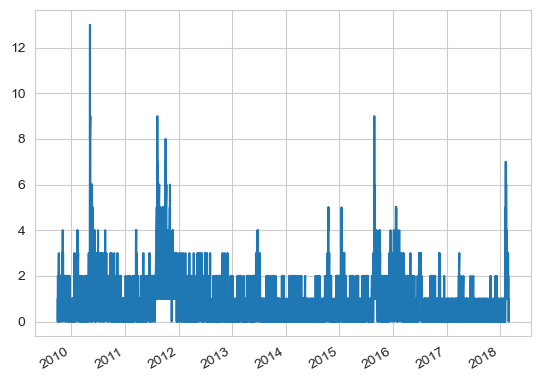

In [10]:
numCoEvents.plot()

Plot the time series of the number of concurrent labels on the primary axis and the time series of exponentially weighted moving standard deviation of returns on the secondary axis

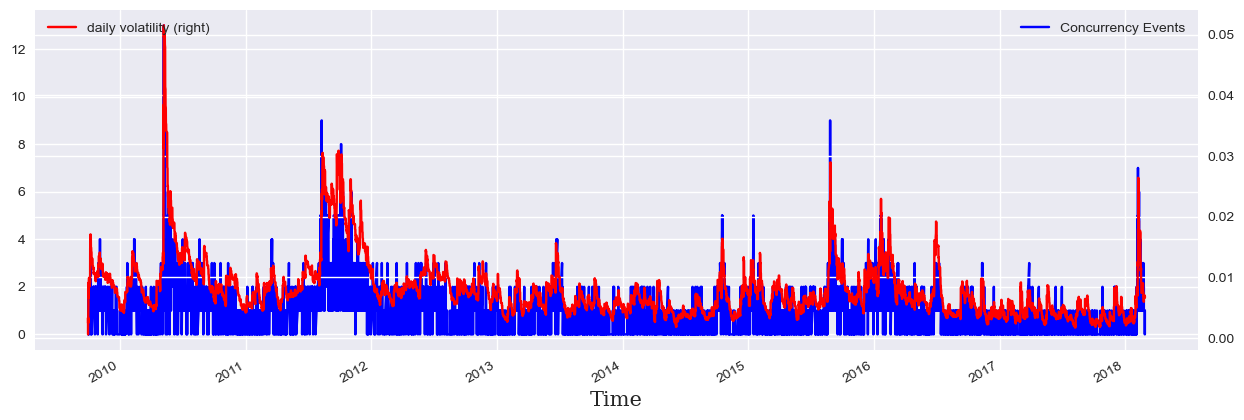

In [11]:
plt.style.use('seaborn')
plt.figure(figsize = (15,5))
plt.xlabel('Time', fontfamily = 'Serif', fontsize = 15)

ax1 = numCoEvents.plot(color = 'blue', grid = True, label = 'Concurrency Events')
ax2 = dailyVol.plot(color = 'red', grid = True, secondary_y = True, label = 'daily volatility')

ax1.legend(loc = 1)
ax2.legend(loc = 2)

Produce a scatter plot of the number of concurrent labels and the exponentially weighted moving standard deviation of returns

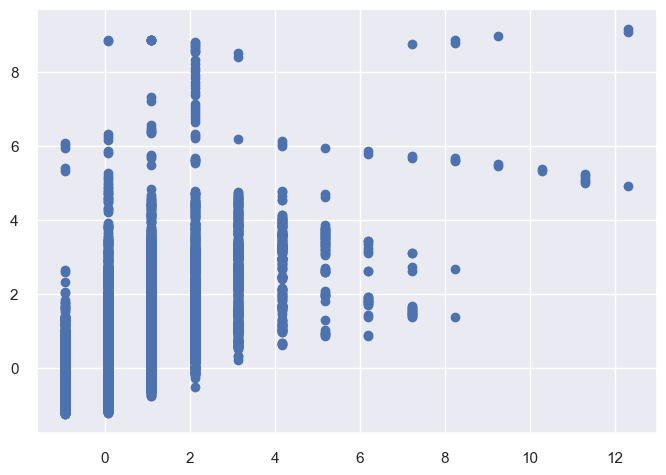

In [12]:
coEvents = numCoEvents.to_frame()
ewmasd = dailyVol.to_frame()
combine = ewmasd.join(coEvents, how = 'inner')
combine.columns = ['ewmasd', 'coEvents']
combine['ewmasd_std'] = (combine['ewmasd']-combine['ewmasd'].mean())/combine['ewmasd'].std()
combine['coEvents_std'] = (combine['coEvents']-combine['coEvents'].mean())/combine['coEvents'].std()

sns.set_theme('notebook')
plt.scatter(combine['coEvents_std'], combine['ewmasd_std'])

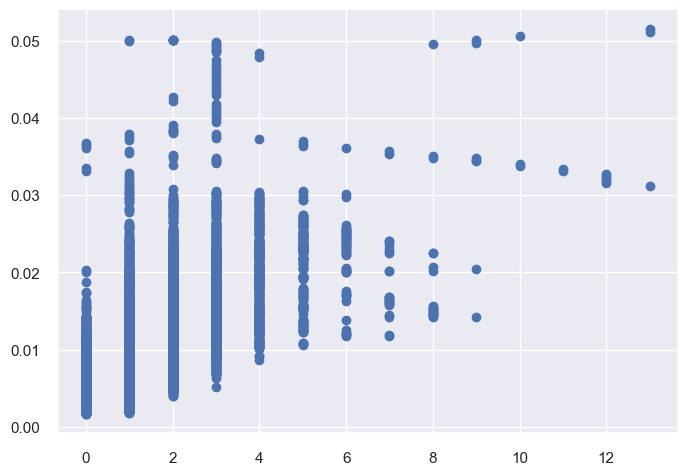

In [13]:
plt.scatter(combine['coEvents'], combine['ewmasd'])

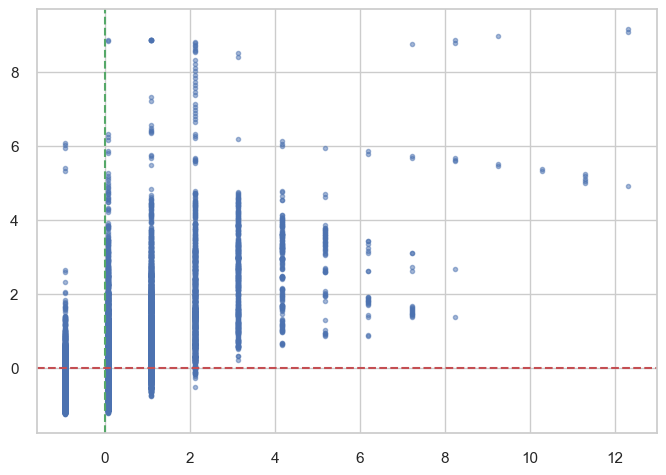

In [14]:
sns.set_style('whitegrid')
plt.scatter(combine['coEvents_std'], combine['ewmasd_std'], marker = '.', alpha = 0.5)
plt.axhline(y = combine['coEvents_std'].mean(), c='r', ls='--')
plt.axvline(x = combine['ewmasd_std'].mean(), c='g', ls='--')
plt.show()

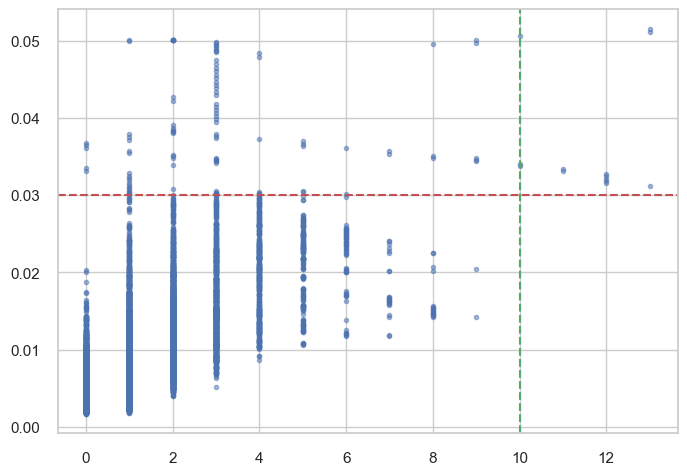

In [15]:
plt.scatter(combine['coEvents'],combine['ewmasd'], marker = '.', alpha = 0.5)
plt.axhline(y = 0.03, c='r', ls='--')
plt.axvline(x = 10, c='g', ls='--')
plt.show()

Compute the Average Uniqueness of each label

In [16]:
sampleTW = fml.SampleTW(close = close, events = events, numThreads = numThreads)
sampleTW

2023-05-04 21:14:52.404589 100.0% mpNumCoEvents done after 0.12 minutes. Remaining 0.0 minutes..
2023-05-04 21:14:59.035736 100.0% mpSampleTW done after 0.09 minutes. Remaining 0.0 minutes..


,t1,tW
2009-09-30 09:45:21,2009-09-30 10:03:53,1.000000
2009-09-30 13:31:12,2009-10-01 09:43:58,0.916667
2009-10-01 09:43:58,2009-10-01 11:12:07,0.800000
2009-10-01 11:12:07,2009-10-01 15:30:21,0.944444
2009-10-02 09:44:14,2009-10-02 10:35:05,0.875000
...,...,...
2018-02-22 12:18:21,2018-02-22 14:56:14,0.484848
2018-02-22 14:56:14,2018-02-23 15:02:21,0.753086
2018-02-23 11:37:32,2018-02-23 15:51:23,0.642857
2018-02-23 15:58:39,2018-02-26 09:30:00,1.000000


In [17]:
import statsmodels.tsa as tsa
ar = tsa.arima.model.ARIMA(sampleTW['tW'], order = (1,0,0))
result = ar.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     tW   No. Observations:                 2277
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1110.639
Date:                Thu, 04 May 2023   AIC                          -2215.279
Time:                        21:15:00   BIC                          -2198.087
Sample:                             0   HQIC                         -2209.008
                               - 2277                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7232      0.021     35.195      0.000       0.683       0.764
ar.L1          0.8339      0.020     42.144      0.000       0.795       0.873
sigma2         0.0221      0.001     30.026      0.000       0.021       0.023
===================================================================================
Ljung-Box (L1) (Q):                  54.86   Jarque-Bera (JB):               210.77
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.31
Prob(H) (two-sided):                  0.66   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Fit a Random Forest to a Financial Dataset

The Mean out of bag accuracy

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, classification_report
from sklearn.preprocessing import StandardScaler

In [19]:
Xy = (pd.DataFrame().assign(close = close, close_lag = close.shift(1))).dropna()

y = Xy.loc[:,'close'].values
X = Xy.loc[:,'close_lag'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    shuffle=False)

n_estimator = 1000
rf = RandomForestRegressor(max_depth = 2,
                           n_estimators = n_estimator, criterion = 'squared_error',
                           oob_score = True, random_state = 42)

In [20]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=1000, oob_score=True,
                      random_state=42)

In [21]:
rf.oob_score_

0.9575767692013495

In [22]:
window = 10
bb_df = pd.DataFrame()
bb_df['price'], bb_df['ave'], bb_df['upper'], bb_df['lower'] = fml.bbands(close, window = window, numsd=1)
bb_df.dropna(inplace = True)
bb_df

,price,ave,upper,lower
2009-09-28 13:24:28,51.46800,51.333,51.444,51.222
2009-09-28 13:54:29,51.50005,51.370,51.469,51.270
2009-09-28 14:15:06,51.42000,51.393,51.473,51.312
2009-09-28 14:26:40,51.46000,51.418,51.472,51.363
2009-09-28 14:44:10,51.48140,51.428,51.484,51.372
...,...,...,...,...
2018-02-26 15:31:06,115.29000,115.178,115.285,115.072
2018-02-26 15:40:15,115.41000,115.207,115.332,115.083
2018-02-26 15:49:42,115.20000,115.212,115.336,115.089
2018-02-26 15:59:04,115.27000,115.231,115.347,115.115


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


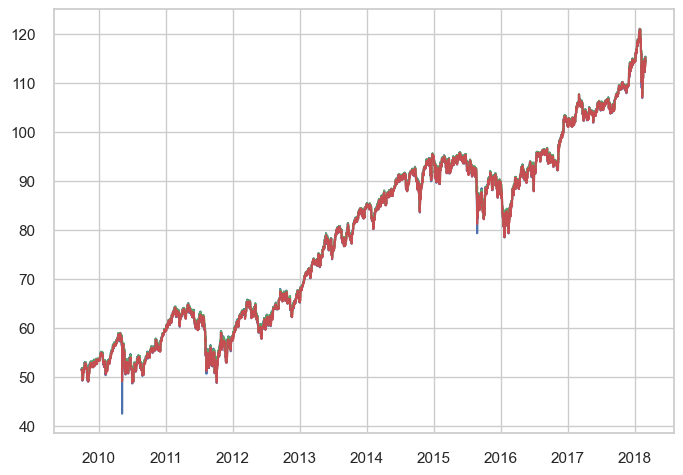

In [23]:
plt.plot(bb_df)
plt.legend(loc = 'upper left')

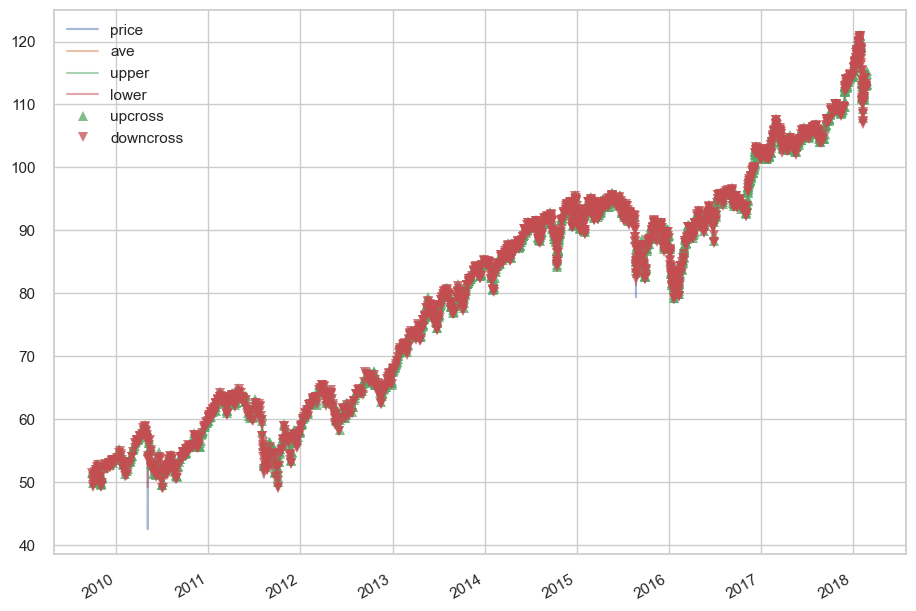

In [24]:
def get_up_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) < df.upper.shift(1)
    crit2 = df[col] > df.upper
    return df[col][(crit1) & (crit2)]

def get_down_cross(df, col):
    # col is price column
    crit1 = df[col].shift(1) > df.lower.shift(1)
    crit2 = df[col] < df.lower
    return df[col][(crit1) & (crit2)]

bb_down = get_down_cross(bb_df, 'price')
bb_up = get_up_cross(bb_df, 'price')
f, ax = plt.subplots(figsize=(11,8))

bb_df.plot(ax=ax, alpha=.5)
bb_up.plot(ax=ax, ls='', marker='^', markersize=7,
                        alpha=0.75, label='upcross', color='g')
bb_down.plot(ax=ax, ls='', marker='v', markersize=7,
                          alpha=0.75, label='downcross', color='r')
ax.legend()

In [25]:
bb_side_up = pd.Series(-1, index = bb_up.index) # sell on up cross for mean reversion
bb_side_down = pd.Series(1, index = bb_down.index) # buy on down cross for mean reversion
bb_side_raw = pd.concat([bb_side_up,bb_side_down]).sort_index()

bb_side_raw

2009-09-28 15:39:46   -1
2009-09-28 15:51:04    1
2009-09-29 09:33:01   -1
2009-09-29 10:40:29   -1
2009-09-29 13:59:56   -1
                      ..
2018-02-23 11:37:32   -1
2018-02-23 13:41:26   -1
2018-02-23 15:02:21   -1
2018-02-26 12:09:16   -1
2018-02-26 15:12:24   -1
Length: 5238, dtype: int64

In [26]:
minRet = .001
ptsl = [1,1]
bb_events = fml.getEvents(close, tEvents, ptsl, target, minRet, cpus, t1=t1, side = bb_side_raw)
bb_events

2023-05-04 21:15:12.004555 100.0% applyPtSlOnT1 done after 0.1 minutes. Remaining 0.0 minutes..


,t1,trgt,side
2009-09-30 09:45:21,2009-09-30 10:03:53,0.005247,1.0
2009-09-30 13:31:12,2009-10-01 13:33:25,0.007211,NaN
2009-10-01 09:43:58,2009-10-01 11:12:07,0.007157,1.0
2009-10-01 11:12:07,2009-10-02 11:50:21,0.006726,NaN
2009-10-02 09:44:14,2009-10-02 10:35:05,0.009808,1.0
...,...,...,...
2018-02-22 12:18:21,2018-02-23 12:30:16,0.007161,NaN
2018-02-22 14:56:14,2018-02-23 15:02:21,0.007178,NaN
2018-02-23 11:37:32,2018-02-23 15:51:23,0.006370,-1.0
2018-02-23 15:58:39,2018-02-26 09:30:00,0.007037,NaN


In [27]:
bb_side = bb_events.dropna().side
bb_side

2009-09-30 09:45:21    1.0
2009-10-01 09:43:58    1.0
2009-10-02 09:44:14    1.0
2009-10-05 09:51:42   -1.0
2009-10-06 09:29:52   -1.0
                      ... 
2018-02-12 09:30:00   -1.0
2018-02-13 09:30:00    1.0
2018-02-15 09:31:56   -1.0
2018-02-21 14:04:12   -1.0
2018-02-23 11:37:32   -1.0
Name: side, Length: 842, dtype: float64

In [28]:
bb_side.value_counts()

-1.0    448
 1.0    394
Name: side, dtype: int64

In [29]:
bb_bins = fml.getBins(bb_events,close).dropna()
bb_bins

,ret,bin
2009-09-30 09:45:21,-0.005472,0.0
2009-10-01 09:43:58,-0.009572,0.0
2009-10-02 09:44:14,0.009951,1.0
2009-10-05 09:51:42,-0.011292,0.0
2009-10-06 09:29:52,-0.000982,0.0
...,...,...
2018-02-12 09:30:00,0.000180,1.0
2018-02-13 09:30:00,0.001803,1.0
2018-02-15 09:31:56,-0.003964,0.0
2018-02-21 14:04:12,0.010028,1.0


In [30]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window = window).corr(df.shift(lag))) # could .dropna() here

srl_corr = df_rolling_autocorr(returns(close), window = window).rename('srl_corr')
srl_corr

2009-09-28 10:06:04         NaN
2009-09-28 10:19:50         NaN
2009-09-28 10:32:01         NaN
2009-09-28 10:53:46         NaN
2009-09-28 11:22:01         NaN
                         ...   
2018-02-26 15:31:06    0.145233
2018-02-26 15:40:15   -0.064710
2018-02-26 15:49:42   -0.338725
2018-02-26 15:59:04   -0.363186
2018-02-26 16:16:14   -0.401999
Name: srl_corr, Length: 30860, dtype: float64

In [31]:
features = (pd.DataFrame()
            .assign(vol=bb_events.trgt)
            .assign(srl_corr = srl_corr)
            .drop_duplicates()
            .dropna())
features

,vol,srl_corr
2009-09-30 09:45:21,0.005247,-0.449043
2009-09-30 13:31:12,0.007211,0.502560
2009-10-01 09:43:58,0.007157,0.286727
2009-10-01 11:12:07,0.006726,0.119127
2009-10-02 09:44:14,0.009808,-0.723917
...,...,...
2018-02-22 12:18:21,0.007161,-0.131514
2018-02-22 14:56:14,0.007178,-0.334990
2018-02-23 11:37:32,0.006370,-0.234899
2018-02-23 15:58:39,0.007037,0.033857


In [32]:
Xy = (pd.merge_asof(features, bb_bins[['bin']],
                    left_index=True, right_index=True,
                    direction='forward').dropna())
Xy

,vol,srl_corr,bin
2009-09-30 09:45:21,0.005247,-0.449043,0.0
2009-09-30 13:31:12,0.007211,0.502560,0.0
2009-10-01 09:43:58,0.007157,0.286727,0.0
2009-10-01 11:12:07,0.006726,0.119127,1.0
2009-10-02 09:44:14,0.009808,-0.723917,1.0
...,...,...,...
2018-02-21 14:04:12,0.008161,-0.394593,1.0
2018-02-21 15:12:30,0.007815,0.539989,0.0
2018-02-22 12:18:21,0.007161,-0.131514,0.0
2018-02-22 14:56:14,0.007178,-0.334990,0.0


### Random Forest

In [33]:
X = Xy.drop('bin',axis = 1).values
y = Xy['bin'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)

              precision    recall  f1-score   support

         0.0       0.50      0.48      0.49       345
         1.0       0.49      0.50      0.49       338

    accuracy                           0.49       683
   macro avg       0.49      0.49      0.49       683
weighted avg       0.49      0.49      0.49       683



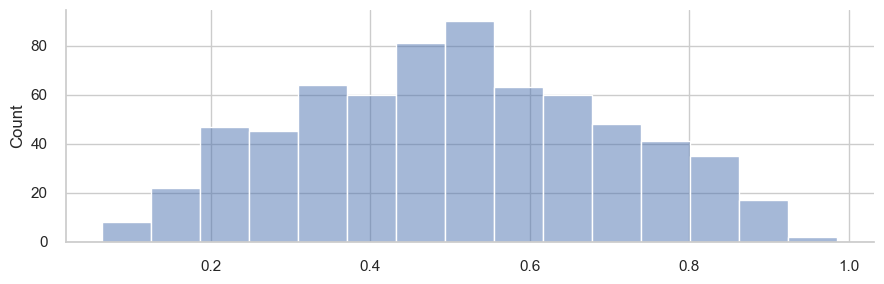

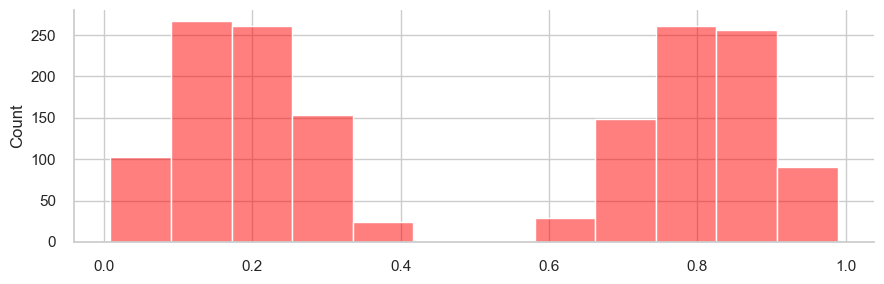

In [34]:
n_estimator = 1000
rf = RandomForestClassifier(n_estimators = n_estimator,
                            criterion = 'entropy', random_state = 42,
                            class_weight = 'balanced_subsample', ccp_alpha = 0.001)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
ax1 = sns.displot(rf.predict_proba(X_test)[:, 1], height = 3, aspect = 3, alpha = 0.5)
ax2 = sns.displot(rf.predict_proba(X_train)[:, 1], height = 3, aspect = 3, color = 'red', alpha = 0.5)
plt.show()

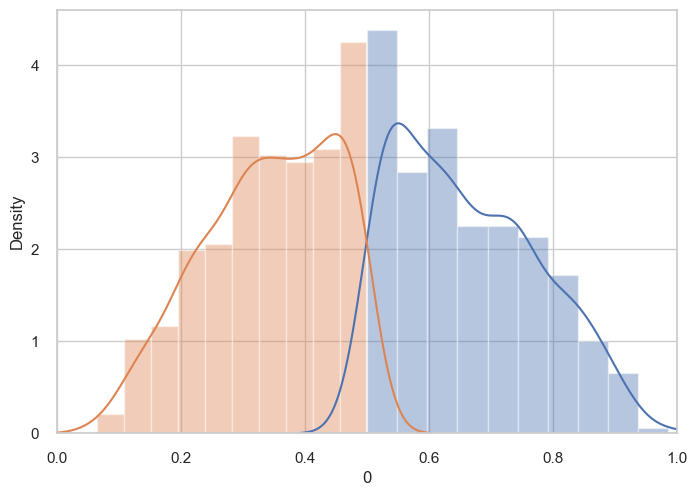

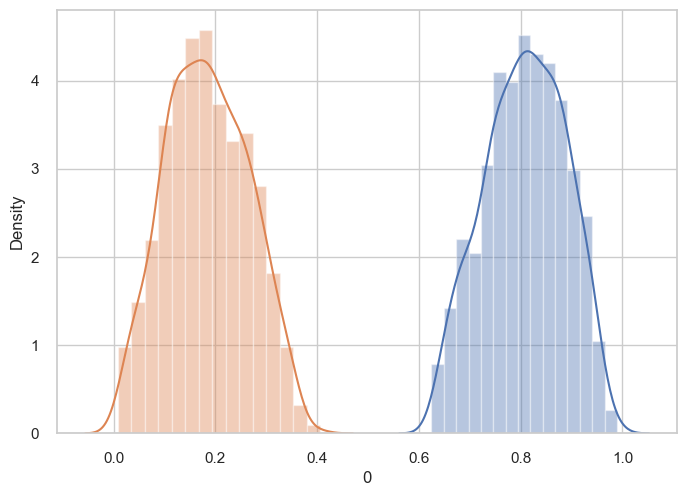

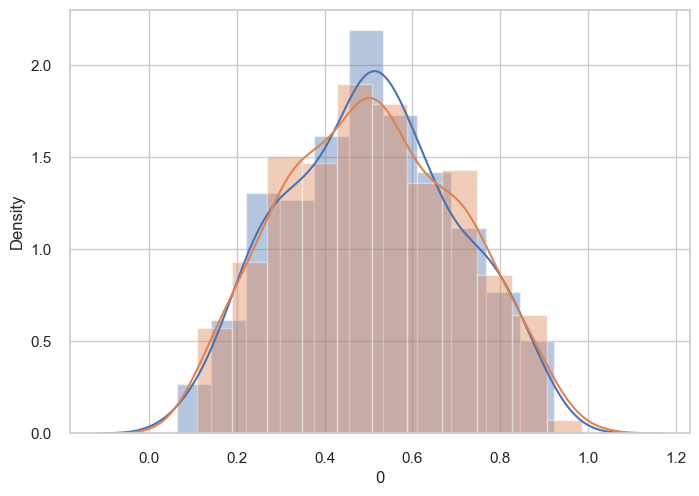

In [35]:
result_df = pd.DataFrame([y_pred_rf, y_pred]).T
train_df = pd.DataFrame([rf.predict_proba(X_train)[:, 1], rf.predict(X_train)]).T

fig, ax = plt.subplots()
for a in [result_df[result_df[1] == 1.0][0], result_df[result_df[1] == 0.0][0]]:
    sns.distplot(a, ax = ax, kde = True)
ax.set_xlim([0, 1])

fig1, ax1 = plt.subplots()
for a in [train_df[train_df[1] == 1.0][0], train_df[train_df[1] == 0.0][0]]:
    sns.distplot(a, ax = ax1, kde = True)
ax.set_xlim([0, 1])

fig1, ax1 = plt.subplots()
for a in [result_df[train_df[1] == 1.0][0], result_df[train_df[1] == 0.0][0]]:
    sns.distplot(a, ax = ax1, kde = True)
ax.set_xlim([0, 1])

plt.show()

In [36]:
result_df # predict

,0,1
0,0.664785,1.0
1,0.332964,0.0
2,0.304151,0.0
3,0.671834,1.0
4,0.449948,0.0
...,...,...
678,0.179681,0.0
679,0.838458,1.0
680,0.269289,0.0
681,0.565685,1.0


### CatBoost

In [38]:
from catboost import CatBoostClassifier

0:	learn: 0.6930970	total: 2.44ms	remaining: 2.44s
1:	learn: 0.6930539	total: 3.6ms	remaining: 1.79s
2:	learn: 0.6930037	total: 4.4ms	remaining: 1.46s
3:	learn: 0.6929618	total: 5.11ms	remaining: 1.27s
4:	learn: 0.6929096	total: 6.06ms	remaining: 1.21s
5:	learn: 0.6928522	total: 6.74ms	remaining: 1.12s
6:	learn: 0.6927826	total: 7.55ms	remaining: 1.07s
7:	learn: 0.6927289	total: 8.4ms	remaining: 1.04s
8:	learn: 0.6926623	total: 9.11ms	remaining: 1s
9:	learn: 0.6926107	total: 9.95ms	remaining: 985ms
10:	learn: 0.6925376	total: 10.7ms	remaining: 962ms
11:	learn: 0.6924930	total: 11.4ms	remaining: 939ms
12:	learn: 0.6924484	total: 12.2ms	remaining: 923ms
13:	learn: 0.6923940	total: 13.2ms	remaining: 933ms
14:	learn: 0.6923536	total: 14ms	remaining: 918ms
15:	learn: 0.6923076	total: 14.8ms	remaining: 910ms
16:	learn: 0.6922597	total: 15.4ms	remaining: 892ms
17:	learn: 0.6922272	total: 16.2ms	remaining: 883ms
18:	learn: 0.6921844	total: 17.2ms	remaining: 890ms
19:	learn: 0.6921306	total: 17

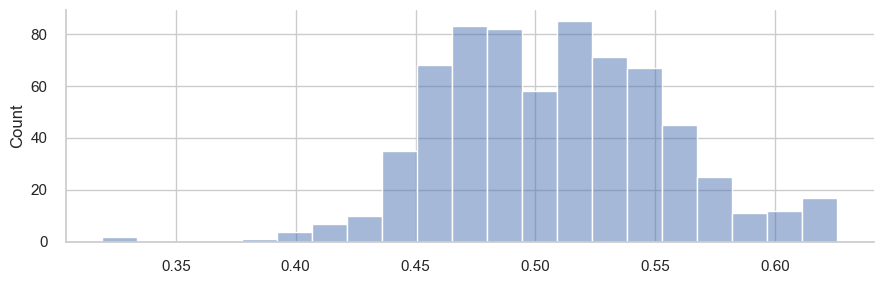

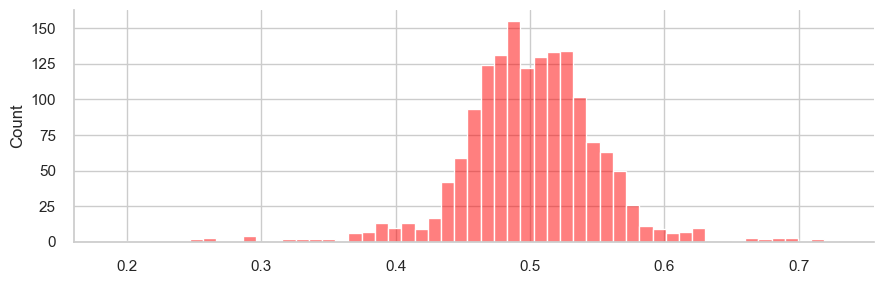

In [55]:
from sklearn.utils.class_weight import compute_class_weight
n_estimator = 1000
classes = np.unique(y_train)
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train)
class_weights = dict(zip(classes, weights))
cb = CatBoostClassifier(class_weights = class_weights,
                        n_estimators = n_estimator,
                        loss_function = 'Logloss',
                        random_state = 42,
                        learning_rate = 0.003)
cb.fit(X_train, y_train)

# The random forest model by itself
y_pred_cb = cb.predict_proba(X_test)[:, 1]
y_pred = cb.predict(X_test)
print(classification_report(y_test, y_pred))
ax1 = sns.displot(cb.predict_proba(X_test)[:, 1], height = 3, aspect = 3, alpha = 0.5)
ax2 = sns.displot(cb.predict_proba(X_train)[:, 1], height = 3, aspect = 3, color = 'red', alpha = 0.5)
plt.show()

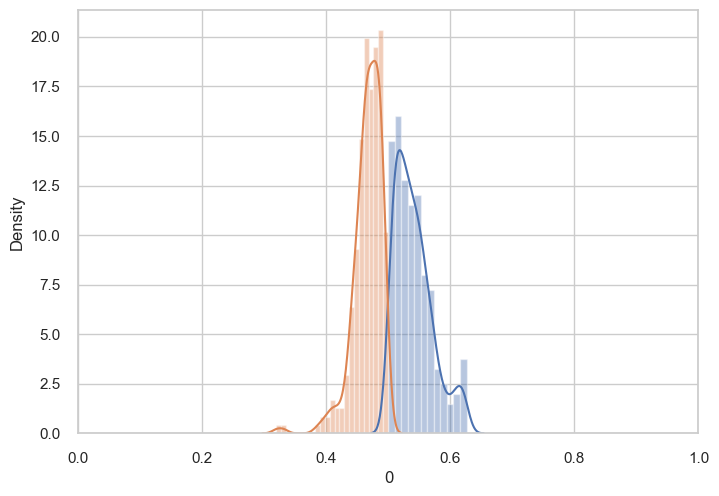

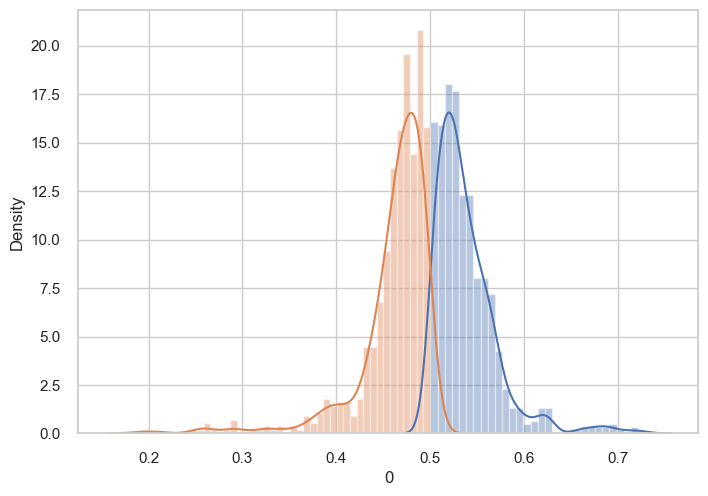

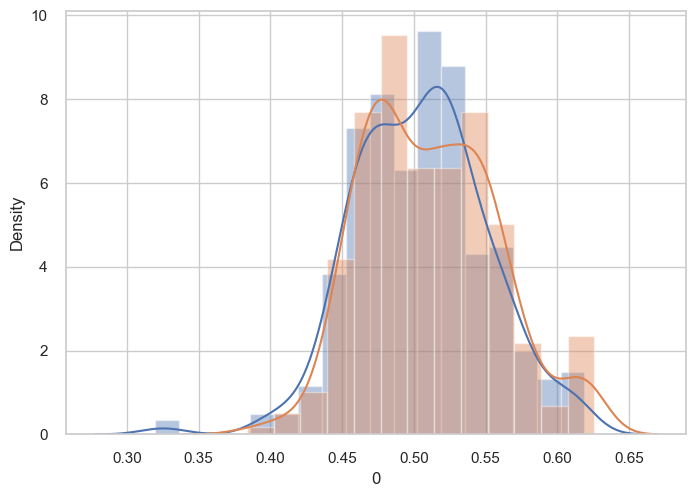

In [56]:
result_df = pd.DataFrame([y_pred_cb, y_pred]).T
train_df = pd.DataFrame([cb.predict_proba(X_train)[:, 1], cb.predict(X_train)]).T

fig, ax = plt.subplots()
for a in [result_df[result_df[1] == 1.0][0], result_df[result_df[1] == 0.0][0]]:
    sns.distplot(a, ax = ax, kde = True)
ax.set_xlim([0, 1])

fig1, ax1 = plt.subplots()
for a in [train_df[train_df[1] == 1.0][0], train_df[train_df[1] == 0.0][0]]:
    sns.distplot(a, ax = ax1, kde = True)
ax.set_xlim([0, 1])

fig1, ax1 = plt.subplots()
for a in [result_df[train_df[1] == 1.0][0], result_df[train_df[1] == 0.0][0]]:
    sns.distplot(a, ax = ax1, kde = True)
ax.set_xlim([0, 1])

plt.show()